In [1]:
import pandas as pd 
import numpy as np
import seaborn as sn 
%pylab inline 

DRAWING = True
IMG = "./figs/"
global_drawing_params = {"dpi": 300, "bbox_inches": "tight"}

Populating the interactive namespace from numpy and matplotlib


# Data Viz & Cleaning

In [2]:
data_o = pd.read_csv("data.arff", skiprows=19, header=None)
data_o.columns = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4", "E" ]
x_cols =  ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

The original paper describes ranges for min and max. Let's view our ranges. 

In [3]:
print("{:6}\t{:5}\t{:5}\t{:5}".format("Channel", "min", "mean", "max"))
for x in x_cols: 
    print("{:6}\t{:5.0f}\t{:5.0f}\t{:5.0f}".format(x, data_o[x].min(), data_o[x].mean(), data_o[x].max()))

Channel	min  	mean 	max  
AF3   	 1031	 4322	309231
F7    	 2831	 4010	 7805
F3    	 1040	 4264	 6881
FC5   	 2453	 4165	642564
T7    	 2090	 4342	 6474
P7    	 2768	 4644	362564
O1    	 2086	 4110	567179
O2    	 4567	 4616	 7264
P8    	 1358	 4219	265641
T8    	 1816	 4231	 6674
FC6   	 3273	 4202	 6823
F4    	 2258	 4279	 7003
F8    	   87	 4615	152308
AF4   	 1366	 4416	715897


We have some obvious discrepencies. Let's also view the graph of this data. 

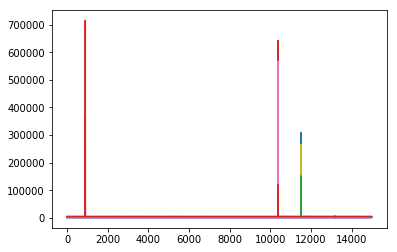

In [4]:
for i in data_o: 
    data_o[i].plot()

Evidently, these are the three transmission errors the paper referenced. So, let's clean that up, replacing by a mean of adjecent points

In [5]:
for i in range(0, 3): 
    for j, col in enumerate(x_cols): 
        amax = data_o[col].idxmax() 
        data_o.iloc[amax, j] = (data_o.iloc[amax - 1, j] + data_o.iloc[amax + 1, j]) / 2
        amin = data_o[col].idxmin() 
        data_o.iloc[amin, j] = (data_o.iloc[amin - 1, j] + data_o.iloc[amin + 1, j]) / 2


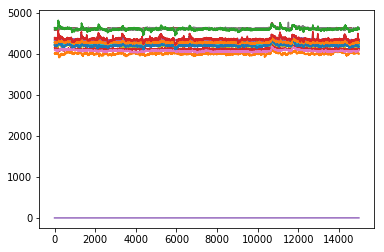

In [6]:
for i in data_o: 
    data_o[i].plot()

## Normalization 

Now we need to move it to center and normalize it. 

In [7]:
new = {}; 
for i in data_o:
    if i != "E": 
        new[i] = (data_o[i] - data_o[i].median())/data_o[i].std() 
    else: 
        new[i] = data_o[i] 
data = pd.DataFrame(new) 

## Viz 

We should see if this data is skewed in any way. A selective log-transform can be applied in presense of a skew to help normalize it. 

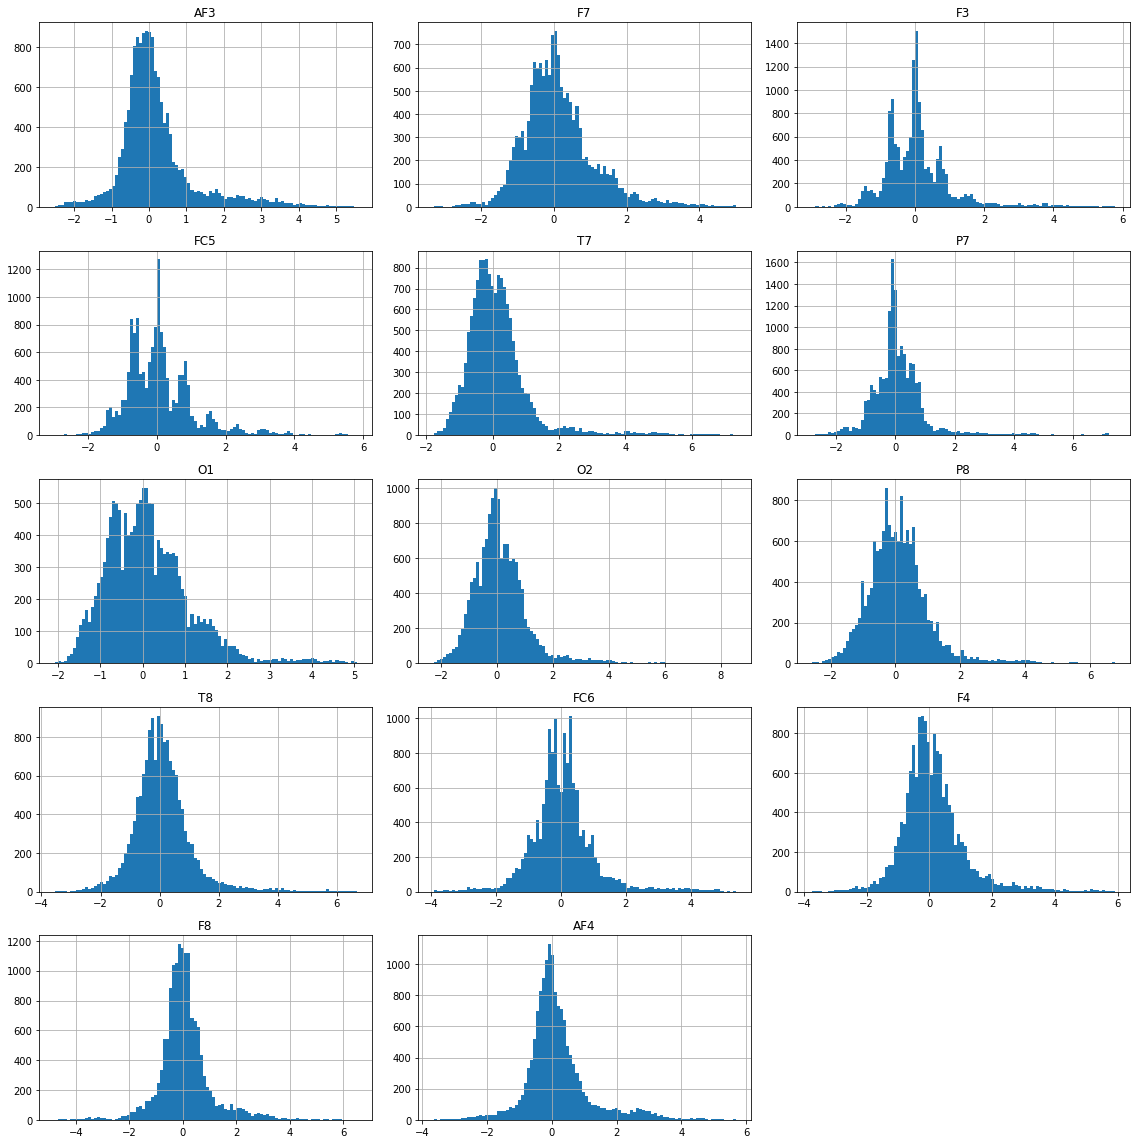

In [8]:
figshape = (5, 3)
fig, axs = plt.subplots(*figshape, figsize=(16, 16))
for i, j in enumerate(x_cols): 
    axind = np.unravel_index(i, figshape)
    ax = axs[axind[0]][axind[1]]
    data[j].hist(ax = ax, bins=100) 
    ax.set_title(j) 
for l in range(i + 1, np.prod(figshape)): 
    axind = np.unravel_index(l, figshape) 
    ax = axs[axind[0]][axind[1]]
    ax.set_axis_off() 
fig.tight_layout()

if DRAWING: 
    fig.savefig(IMG + "channel_histogram.png", **global_drawing_params)

We can see that there isn't much of a skew. 

# Tensorflow

The [original paper](http://suendermann.com/su/pdf/aihls2013.pdf) describes using a blending of the 40% with the [K-Star algorithm](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/KStar.pdf). Let's see if we can beat that 

In [9]:
import tensorflow as tf

Our input is a length 14 vector and our output is a classification of 1 or 0 based on open or closed. The following construct lets us choose how many seconds we want. it's set to 117, so we have 1/117^2 aka 1 single input. 

In [10]:
shape = data_o.shape[0] // (117 * 117) , 14 

## Setup Input Function 

The algorithm mostly comes into play when we have history included. 

In [11]:
from sklearn.model_selection import train_test_split

input_vector = np.zeros((data_o.shape[0] - shape[0], np.prod(shape)))
output_vector = np.zeros((data_o.shape[0] - shape[0], 1))

for i in range(shape[0], data_o.shape[0]): 
    input_vector[i - shape[0], :] = data.iloc[i - shape[0]:i, :-1].values.flatten()
    output_vector[i - shape[0]] = data['E'][i].astype(int)

train_x, test_x, train_y, test_y = train_test_split(input_vector, output_vector)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": train_x}, 
    y = train_y.astype(int), 
    batch_size = 50, 
    num_epochs = None, 
    shuffle = True
)

## Define Model 

In [12]:
def model_fn(features, labels, mode, **params): 
    # the input is a tensor 
    dense1 = tf.layers.dense( 
        inputs = features['x'], 
        units = int(np.sqrt(np.prod(shape))) * 2, 
        activation = tf.nn.sigmoid, 
        name="Input_Activation"
    )
    # Reactivate with softplus to let any startlingly high inputs
    # be amplified 
    second_seg = tf.layers.dense(
        inputs = dense1,
        units = int(np.sqrt(np.prod(shape))), 
        activation = tf.nn.softplus, 
        name="Softplus"
    )

    # Dropout -- softplus seems dangerous  
    dropout = tf.layers.dropout (
        inputs = second_seg, 
        rate = 0.25, 
        training= mode == tf.estimator.ModeKeys.TRAIN, 
        name="Dropout"
    )

    # Reactivate the softplus  
    dense2 = tf.layers.dense(
        inputs = dropout,
        units = int(np.sqrt(np.prod(shape))), 
        activation = tf.nn.tanh, 
        name="Dense_Layer_sqrt_X"
    )
    # And once more, with an arbitrarly large layer. 
    dense3 = tf.layers.dense (
        inputs = dense2, 
        units = 1000, 
        activation = tf.nn.tanh, 
        name="Dense_Layer_1000"
    )
    #Compact this with ReLU into our output.  
    res = tf.layers.dense (
        inputs = dense3, 
        activation = tf.nn.relu,
        units = 2,
        name="Output"
    )
    predictions = {
        'classes': tf.argmax(input=res, axis=1), 
        "probabilities": tf.nn.softmax(res, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT: 
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = res)
    
    tf.summary.scalar("loss", loss) 
    tf.summary.tensor_summary("result", res) 
    if mode == tf.estimator.ModeKeys.TRAIN: 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
        train_op = optimizer.minimize(
            loss = loss, 
            global_step = tf.train.get_global_step() 
        )
        return tf.estimator.EstimatorSpec(mode = mode, loss=loss, train_op = train_op)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy (
            labels = labels, 
            predictions = predictions["classes"]
        )
    }
    
    return tf.estimator.EstimatorSpec(
    mode = mode, loss=loss, eval_metric_ops = eval_metric_ops)    

In [13]:
log_dir = "model_cache" 
tf.gfile.MakeDirs(log_dir)

eye_classifier = tf.estimator.Estimator(
    model_fn = model_fn, 
    model_dir = log_dir
)
eye_classifier.train(input_fn= train_input_fn, steps=100000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into model_cache/model.ckpt.
INFO:tensorflow:loss = 0.691584408283, step = 1
INFO:tensorflow:global_step/sec: 399.111
INFO:tensorflow:loss = 0.694866538048, step = 101 (0.252 sec)
INFO:tensorflow:global_step/sec: 374.676
INFO:tensorflow:loss = 0.679300308228, step = 201 (0.267 sec)
INFO:tensorflow:global_step/sec: 360.486
INFO:tensorflow:loss = 0.700457632542, step = 301 (0.278 sec)
INFO:tensorflow:global_step/sec: 363.606
INFO:tensorflow:loss = 0.679376780987, step = 401 (0.274 sec)
INFO:tensorflow:global_step/sec: 384.243
INFO:tensorflow:loss = 0.704013288021, step = 501 (0.260 sec)
INFO:tensorflow:global_step/sec: 301.343
INFO:tensorflow:loss = 0.689850926399, step = 601 (0.333 sec)
INFO:tensorflow:global_step/sec: 360.112
INFO:tensorflow:loss = 0.658076763153, step = 701 (0.277 sec)
INFO:tensorflow:global_step/sec: 408.8
INFO:te

INFO:tensorflow:global_step/sec: 346.954
INFO:tensorflow:loss = 0.690986692905, step = 7801 (0.288 sec)
INFO:tensorflow:global_step/sec: 367.422
INFO:tensorflow:loss = 0.698229134083, step = 7901 (0.272 sec)
INFO:tensorflow:global_step/sec: 399.435
INFO:tensorflow:loss = 0.698822915554, step = 8001 (0.250 sec)
INFO:tensorflow:global_step/sec: 308.491
INFO:tensorflow:loss = 0.723571419716, step = 8101 (0.324 sec)
INFO:tensorflow:global_step/sec: 315.625
INFO:tensorflow:loss = 0.698890209198, step = 8201 (0.317 sec)
INFO:tensorflow:global_step/sec: 392.241
INFO:tensorflow:loss = 0.674379527569, step = 8301 (0.255 sec)
INFO:tensorflow:global_step/sec: 407.173
INFO:tensorflow:loss = 0.699251651764, step = 8401 (0.245 sec)
INFO:tensorflow:global_step/sec: 401.257
INFO:tensorflow:loss = 0.6679880023, step = 8501 (0.249 sec)
INFO:tensorflow:global_step/sec: 422.122
INFO:tensorflow:loss = 0.662030935287, step = 8601 (0.237 sec)
INFO:tensorflow:global_step/sec: 397.444
INFO:tensorflow:loss = 0.

INFO:tensorflow:global_step/sec: 418.831
INFO:tensorflow:loss = 0.644911825657, step = 15701 (0.239 sec)
INFO:tensorflow:global_step/sec: 411.609
INFO:tensorflow:loss = 0.691681921482, step = 15801 (0.243 sec)
INFO:tensorflow:global_step/sec: 386.366
INFO:tensorflow:loss = 0.60612398386, step = 15901 (0.259 sec)
INFO:tensorflow:global_step/sec: 423.521
INFO:tensorflow:loss = 0.559995472431, step = 16001 (0.236 sec)
INFO:tensorflow:global_step/sec: 356.796
INFO:tensorflow:loss = 0.682240724564, step = 16101 (0.281 sec)
INFO:tensorflow:global_step/sec: 386.008
INFO:tensorflow:loss = 0.59718298912, step = 16201 (0.258 sec)
INFO:tensorflow:global_step/sec: 374.79
INFO:tensorflow:loss = 0.572236061096, step = 16301 (0.267 sec)
INFO:tensorflow:global_step/sec: 395.141
INFO:tensorflow:loss = 0.601285874844, step = 16401 (0.253 sec)
INFO:tensorflow:global_step/sec: 396.073
INFO:tensorflow:loss = 0.624477028847, step = 16501 (0.253 sec)
INFO:tensorflow:global_step/sec: 421.487
INFO:tensorflow:l

INFO:tensorflow:loss = 0.212471067905, step = 23501 (0.266 sec)
INFO:tensorflow:global_step/sec: 339.683
INFO:tensorflow:loss = 0.139768108726, step = 23601 (0.295 sec)
INFO:tensorflow:global_step/sec: 316.348
INFO:tensorflow:loss = 0.178865164518, step = 23701 (0.316 sec)
INFO:tensorflow:global_step/sec: 337.581
INFO:tensorflow:loss = 0.208784908056, step = 23801 (0.296 sec)
INFO:tensorflow:global_step/sec: 378.515
INFO:tensorflow:loss = 0.189751014113, step = 23901 (0.264 sec)
INFO:tensorflow:global_step/sec: 363.814
INFO:tensorflow:loss = 0.174835398793, step = 24001 (0.275 sec)
INFO:tensorflow:global_step/sec: 376.412
INFO:tensorflow:loss = 0.202706933022, step = 24101 (0.266 sec)
INFO:tensorflow:global_step/sec: 363.696
INFO:tensorflow:loss = 0.187338009477, step = 24201 (0.275 sec)
INFO:tensorflow:global_step/sec: 415.195
INFO:tensorflow:loss = 0.135223820806, step = 24301 (0.241 sec)
INFO:tensorflow:global_step/sec: 362.045
INFO:tensorflow:loss = 0.223122745752, step = 24401 (0.

INFO:tensorflow:global_step/sec: 205.782
INFO:tensorflow:loss = 0.211017429829, step = 31401 (0.485 sec)
INFO:tensorflow:global_step/sec: 280.545
INFO:tensorflow:loss = 0.143462643027, step = 31501 (0.355 sec)
INFO:tensorflow:global_step/sec: 238.607
INFO:tensorflow:loss = 0.197881102562, step = 31601 (0.419 sec)
INFO:tensorflow:global_step/sec: 282.503
INFO:tensorflow:loss = 0.101186715066, step = 31701 (0.355 sec)
INFO:tensorflow:global_step/sec: 345.32
INFO:tensorflow:loss = 0.225605979562, step = 31801 (0.289 sec)
INFO:tensorflow:global_step/sec: 382.461
INFO:tensorflow:loss = 0.128052353859, step = 31901 (0.261 sec)
INFO:tensorflow:global_step/sec: 404.794
INFO:tensorflow:loss = 0.197809949517, step = 32001 (0.247 sec)
INFO:tensorflow:global_step/sec: 317.961
INFO:tensorflow:loss = 0.196925282478, step = 32101 (0.315 sec)
INFO:tensorflow:global_step/sec: 335.149
INFO:tensorflow:loss = 0.141582757235, step = 32201 (0.300 sec)
INFO:tensorflow:global_step/sec: 351.803
INFO:tensorflow

INFO:tensorflow:loss = 0.140791684389, step = 39201 (0.280 sec)
INFO:tensorflow:global_step/sec: 355.257
INFO:tensorflow:loss = 0.223772346973, step = 39301 (0.280 sec)
INFO:tensorflow:global_step/sec: 329.007
INFO:tensorflow:loss = 0.195910155773, step = 39401 (0.304 sec)
INFO:tensorflow:global_step/sec: 351.542
INFO:tensorflow:loss = 0.195907816291, step = 39501 (0.284 sec)
INFO:tensorflow:global_step/sec: 306.988
INFO:tensorflow:loss = 0.182384818792, step = 39601 (0.326 sec)
INFO:tensorflow:global_step/sec: 363.086
INFO:tensorflow:loss = 0.140601888299, step = 39701 (0.275 sec)
INFO:tensorflow:global_step/sec: 361.545
INFO:tensorflow:loss = 0.195725917816, step = 39801 (0.277 sec)
INFO:tensorflow:global_step/sec: 322.18
INFO:tensorflow:loss = 0.126775756478, step = 39901 (0.310 sec)
INFO:tensorflow:global_step/sec: 338.787
INFO:tensorflow:loss = 0.182103157043, step = 40001 (0.296 sec)
INFO:tensorflow:global_step/sec: 348.357
INFO:tensorflow:loss = 0.154253408313, step = 40101 (0.2

INFO:tensorflow:global_step/sec: 376.417
INFO:tensorflow:loss = 0.0993298888206, step = 47101 (0.266 sec)
INFO:tensorflow:global_step/sec: 374.881
INFO:tensorflow:loss = 0.167828068137, step = 47201 (0.267 sec)
INFO:tensorflow:global_step/sec: 317.362
INFO:tensorflow:loss = 0.181784614921, step = 47301 (0.315 sec)
INFO:tensorflow:global_step/sec: 366.195
INFO:tensorflow:loss = 0.140927359462, step = 47401 (0.273 sec)
INFO:tensorflow:global_step/sec: 362.479
INFO:tensorflow:loss = 0.16891938448, step = 47501 (0.276 sec)
INFO:tensorflow:global_step/sec: 350.288
INFO:tensorflow:loss = 0.126404061913, step = 47601 (0.285 sec)
INFO:tensorflow:global_step/sec: 398.477
INFO:tensorflow:loss = 0.126781612635, step = 47701 (0.251 sec)
INFO:tensorflow:global_step/sec: 375.577
INFO:tensorflow:loss = 0.167836844921, step = 47801 (0.266 sec)
INFO:tensorflow:global_step/sec: 401.915
INFO:tensorflow:loss = 0.14103372395, step = 47901 (0.249 sec)
INFO:tensorflow:global_step/sec: 393.142
INFO:tensorflow

INFO:tensorflow:loss = 0.195152550936, step = 54901 (0.282 sec)
INFO:tensorflow:global_step/sec: 370.465
INFO:tensorflow:loss = 0.195176675916, step = 55001 (0.270 sec)
INFO:tensorflow:global_step/sec: 366.463
INFO:tensorflow:loss = 0.112107522786, step = 55101 (0.273 sec)
INFO:tensorflow:global_step/sec: 336.27
INFO:tensorflow:loss = 0.139845579863, step = 55201 (0.297 sec)
INFO:tensorflow:global_step/sec: 354.084
INFO:tensorflow:loss = 0.12611438334, step = 55301 (0.282 sec)
INFO:tensorflow:global_step/sec: 358.113
INFO:tensorflow:loss = 0.153968185186, step = 55401 (0.279 sec)
INFO:tensorflow:global_step/sec: 358.814
INFO:tensorflow:loss = 0.195420175791, step = 55501 (0.278 sec)
INFO:tensorflow:global_step/sec: 355.215
INFO:tensorflow:loss = 0.209619030356, step = 55601 (0.282 sec)
INFO:tensorflow:global_step/sec: 314.147
INFO:tensorflow:loss = 0.167745053768, step = 55701 (0.318 sec)
INFO:tensorflow:global_step/sec: 380.8
INFO:tensorflow:loss = 0.195440411568, step = 55801 (0.263 

INFO:tensorflow:global_step/sec: 375.32
INFO:tensorflow:loss = 0.327325552702, step = 62801 (0.266 sec)
INFO:tensorflow:global_step/sec: 402.944
INFO:tensorflow:loss = 0.185038000345, step = 62901 (0.248 sec)
INFO:tensorflow:global_step/sec: 403.029
INFO:tensorflow:loss = 0.154138594866, step = 63001 (0.248 sec)
INFO:tensorflow:global_step/sec: 397.4
INFO:tensorflow:loss = 0.18123742938, step = 63101 (0.252 sec)
INFO:tensorflow:global_step/sec: 344.624
INFO:tensorflow:loss = 0.209371045232, step = 63201 (0.290 sec)
INFO:tensorflow:global_step/sec: 366.808
INFO:tensorflow:loss = 0.21009477973, step = 63301 (0.273 sec)
INFO:tensorflow:global_step/sec: 367.798
INFO:tensorflow:loss = 0.181382805109, step = 63401 (0.272 sec)
INFO:tensorflow:global_step/sec: 375.398
INFO:tensorflow:loss = 0.153983071446, step = 63501 (0.267 sec)
INFO:tensorflow:global_step/sec: 412.125
INFO:tensorflow:loss = 0.112532541156, step = 63601 (0.243 sec)
INFO:tensorflow:global_step/sec: 414.386
INFO:tensorflow:los

INFO:tensorflow:loss = 0.153598487377, step = 70601 (0.245 sec)
INFO:tensorflow:global_step/sec: 380.242
INFO:tensorflow:loss = 0.167587906122, step = 70701 (0.263 sec)
INFO:tensorflow:global_step/sec: 399.819
INFO:tensorflow:loss = 0.0451992116868, step = 70801 (0.250 sec)
INFO:tensorflow:global_step/sec: 381.606
INFO:tensorflow:loss = 0.209017693996, step = 70901 (0.262 sec)
INFO:tensorflow:global_step/sec: 339.944
INFO:tensorflow:loss = 0.21853685379, step = 71001 (0.295 sec)
INFO:tensorflow:global_step/sec: 351.889
INFO:tensorflow:loss = 0.168002530932, step = 71101 (0.283 sec)
INFO:tensorflow:global_step/sec: 328.248
INFO:tensorflow:loss = 0.181202426553, step = 71201 (0.305 sec)
INFO:tensorflow:global_step/sec: 370.528
INFO:tensorflow:loss = 0.139621257782, step = 71301 (0.270 sec)
INFO:tensorflow:global_step/sec: 420.755
INFO:tensorflow:loss = 0.167704775929, step = 71401 (0.238 sec)
INFO:tensorflow:global_step/sec: 415.804
INFO:tensorflow:loss = 0.290847569704, step = 71501 (0.

INFO:tensorflow:global_step/sec: 399.211
INFO:tensorflow:loss = 0.167611822486, step = 78501 (0.250 sec)
INFO:tensorflow:global_step/sec: 424.488
INFO:tensorflow:loss = 0.23635314405, step = 78601 (0.236 sec)
INFO:tensorflow:global_step/sec: 417.301
INFO:tensorflow:loss = 0.112217471004, step = 78701 (0.240 sec)
INFO:tensorflow:global_step/sec: 419.911
INFO:tensorflow:loss = 0.168554499745, step = 78801 (0.238 sec)
INFO:tensorflow:global_step/sec: 400.349
INFO:tensorflow:loss = 0.208754003048, step = 78901 (0.250 sec)
INFO:tensorflow:global_step/sec: 410.128
INFO:tensorflow:loss = 0.167094111443, step = 79001 (0.244 sec)
INFO:tensorflow:global_step/sec: 403.356
INFO:tensorflow:loss = 0.250579923391, step = 79101 (0.250 sec)
INFO:tensorflow:global_step/sec: 392.463
INFO:tensorflow:loss = 0.195824831724, step = 79201 (0.253 sec)
INFO:tensorflow:global_step/sec: 399.549
INFO:tensorflow:loss = 0.19531019032, step = 79301 (0.250 sec)
INFO:tensorflow:global_step/sec: 409.309
INFO:tensorflow:

INFO:tensorflow:loss = 0.125755578279, step = 86301 (0.271 sec)
INFO:tensorflow:global_step/sec: 363.367
INFO:tensorflow:loss = 0.223484605551, step = 86401 (0.275 sec)
INFO:tensorflow:global_step/sec: 293.079
INFO:tensorflow:loss = 0.264167279005, step = 86501 (0.342 sec)
INFO:tensorflow:global_step/sec: 341.793
INFO:tensorflow:loss = 0.275820016861, step = 86601 (0.292 sec)
INFO:tensorflow:global_step/sec: 275.39
INFO:tensorflow:loss = 0.209181934595, step = 86701 (0.363 sec)
INFO:tensorflow:global_step/sec: 308
INFO:tensorflow:loss = 0.112538442016, step = 86801 (0.324 sec)
INFO:tensorflow:global_step/sec: 313.587
INFO:tensorflow:loss = 0.194972082973, step = 86901 (0.319 sec)
INFO:tensorflow:global_step/sec: 351.508
INFO:tensorflow:loss = 0.225616842508, step = 87001 (0.284 sec)
INFO:tensorflow:global_step/sec: 344.541
INFO:tensorflow:loss = 0.140242904425, step = 87101 (0.290 sec)
INFO:tensorflow:global_step/sec: 376.078
INFO:tensorflow:loss = 0.236511692405, step = 87201 (0.266 s

INFO:tensorflow:global_step/sec: 390.842
INFO:tensorflow:loss = 0.167330697179, step = 94201 (0.256 sec)
INFO:tensorflow:global_step/sec: 413.116
INFO:tensorflow:loss = 0.140785574913, step = 94301 (0.242 sec)
INFO:tensorflow:global_step/sec: 413.31
INFO:tensorflow:loss = 0.182117953897, step = 94401 (0.242 sec)
INFO:tensorflow:global_step/sec: 377.522
INFO:tensorflow:loss = 0.18099847436, step = 94501 (0.265 sec)
INFO:tensorflow:global_step/sec: 390.858
INFO:tensorflow:loss = 0.266846805811, step = 94601 (0.256 sec)
INFO:tensorflow:global_step/sec: 423.93
INFO:tensorflow:loss = 0.424234956503, step = 94701 (0.236 sec)
INFO:tensorflow:global_step/sec: 414.695
INFO:tensorflow:loss = 0.307137101889, step = 94801 (0.242 sec)
INFO:tensorflow:global_step/sec: 373.027
INFO:tensorflow:loss = 0.222463667393, step = 94901 (0.267 sec)
INFO:tensorflow:global_step/sec: 401.251
INFO:tensorflow:loss = 0.180887967348, step = 95001 (0.249 sec)
INFO:tensorflow:global_step/sec: 395.27
INFO:tensorflow:lo

In [14]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn (
    x = {"x": test_x}, 
    y = test_y.astype(int), 
    num_epochs = 5, 
    shuffle = True
)

eval_results = eye_classifier.evaluate(input_fn = eval_input_fn) 
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-04-22-20:14:38
INFO:tensorflow:Restoring parameters from model_cache/model.ckpt-100000
INFO:tensorflow:Finished evaluation at 2018-04-22-20:14:38
INFO:tensorflow:Saving dict for global step 100000: accuracy = 0.997864, global_step = 100000, loss = 0.0191776
{'accuracy': 0.99786383, 'loss': 0.01917756, 'global_step': 100000}
